In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import os
df = pd.read_csv('dataset_train.csv',sep=';')
def dfdel(value):
    return len(eval(value))
print(len(df))
df = df[df['Data_2'].map(dfdel)!=0]
df = df[df['Data_2'].map(dfdel)==240]

31383


In [3]:
class0 = df[df['Class_label']==0]
class1 = df[df['Class_label']==1]
class2 = df[df['Class_label']==2]
count = [len(class0),len(class1),len(class2)]
min(count)

6385

In [4]:
data = pd.concat([class0[:min(count)-1],class1[:min(count)-1],class2[:min(count)-1]])

In [5]:
df.head()

,Filename,Test_index,Presentation,Question,Data,Data_2,Class_label
0,6ffe4933-3202-451b-ae6b-fee85cafc829,2,3,7,"[298, 296, 2, -455, -703, -596, -262, -44, 28,...","[-918, -1078, -450, 640, 1503, 1635, 1083, 589...",1
1,8de3189c-8e95-43a2-b6d2-743f097a57fb,0,1,0,"[99, 75, -228, -588, -583, -465, -394, -363, -...","[499, 494, 520, 577, 595, 584, 575, 567, 561, ...",0
2,c74f5292-c8e8-4ef2-a963-7d035e5e3330,3,3,1,"[-369, -543, -644, -670, -636, -586, -524, -44...","[263, 444, 548, 576, 539, 485, 419, 331, 266, ...",2
3,c856d82f-917e-461c-a91f-5298926b8b31,0,3,6,"[-6, -32, -152, -253, -275, -246, -211, -197, ...","[2, 138, 782, 1314, 1471, 1354, 1183, 1127, 10...",1
4,00b38188-82ee-4f1d-9661-485338815751,3,1,2,"[165, 178, 190, 202, 218, 230, 200, 121, 71, 8...","[-722, -711, -700, -686, -669, -665, -712, -79...",2


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['Data_2'], data['Class_label'], test_size=0.33, random_state=42)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [7]:
def normal(X):
    _min = min(X)
    if _min<0:
        for i in range(len(X)):
            X[i]=X[i]-_min
    _max = max(X)
    for i in range(len(X)):
            X[i]=X[i]/_max
    return X

In [8]:
normal([3,5,7,10,-5,4,-3,1,0])

[0.5333333333333333,
 0.6666666666666666,
 0.8,
 1.0,
 0.0,
 0.6,
 0.13333333333333333,
 0.4,
 0.3333333333333333]

In [9]:
X_train=list(X_train)
X_test=list(X_test)
def convX(X):
    for i in range(len(X)):
     X[i]=list(eval(X[i]))
    return np.array(X)
x_train = convX(X_train)
x_test=convX(X_test)

In [10]:
xx = []
for i in x_test:
    xx.append(len(i))
print(set(xx))

{240}


In [11]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [12]:
num_classes = len(np.unique(y_train))
print(num_classes)

3


In [13]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [14]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [15]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [16]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_v2_data2.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
321/321 [==============================] - 7s 20ms/step - loss: 1.1128 - sparse_categorical_accuracy: 0.3483 - val_loss: 1.1497 - val_sparse_categorical_accuracy: 0.3354 - lr: 0.0010
Epoch 2/500
321/321 [==============================] - 6s 20ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.3564 - val_loss: 1.1029 - val_sparse_categorical_accuracy: 0.3642 - lr: 0.0010
Epoch 3/500
321/321 [==============================] - 6s 20ms/step - loss: 1.1011 - sparse_categorical_accuracy: 0.3549 - val_loss: 1.0962 - val_sparse_categorical_accuracy: 0.3674 - lr: 0.0010
Epoch 4/500
321/321 [==============================] - 6s 20ms/step - loss: 1.0999 - sparse_categorical_accuracy: 0.3581 - val_loss: 1.1007 - val_sparse_categorical_accuracy: 0.3498 - lr: 0.0010
Epoch 5/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0995 - sparse_categorical_accuracy: 0.3616 - val_loss: 1.1048 - val_sparse_categorical_accuracy: 0.3518 - lr: 0.0010
Epoch 6/500
321/321 [====

Epoch 43/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.3646 - lr: 0.0010
Epoch 44/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0927 - sparse_categorical_accuracy: 0.3744 - val_loss: 1.1009 - val_sparse_categorical_accuracy: 0.3705 - lr: 0.0010
Epoch 45/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0935 - sparse_categorical_accuracy: 0.3713 - val_loss: 1.0933 - val_sparse_categorical_accuracy: 0.3689 - lr: 0.0010
Epoch 46/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.3777 - val_loss: 1.0936 - val_sparse_categorical_accuracy: 0.3705 - lr: 0.0010
Epoch 47/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.3728 - val_loss: 1.0994 - val_sparse_categorical_accuracy: 0.3728 - lr: 0.0010
Epoch 48/500
321/321

Epoch 125/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0855 - sparse_categorical_accuracy: 0.3930 - val_loss: 1.0926 - val_sparse_categorical_accuracy: 0.3849 - lr: 1.2500e-04
Epoch 126/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0847 - sparse_categorical_accuracy: 0.3941 - val_loss: 1.0910 - val_sparse_categorical_accuracy: 0.3794 - lr: 1.2500e-04
Epoch 127/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0855 - sparse_categorical_accuracy: 0.3910 - val_loss: 1.0914 - val_sparse_categorical_accuracy: 0.3872 - lr: 1.2500e-04
Epoch 128/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0859 - sparse_categorical_accuracy: 0.3913 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.3872 - lr: 1.2500e-04
Epoch 129/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0856 - sparse_categorical_accuracy: 0.3955 - val_loss: 1.0922 - val_sparse_categorical_accuracy: 0.3857 - lr: 1.2500

Epoch 166/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0843 - sparse_categorical_accuracy: 0.3952 - val_loss: 1.0915 - val_sparse_categorical_accuracy: 0.3822 - lr: 1.0000e-04
Epoch 167/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0844 - sparse_categorical_accuracy: 0.3942 - val_loss: 1.0911 - val_sparse_categorical_accuracy: 0.3825 - lr: 1.0000e-04
Epoch 168/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0848 - sparse_categorical_accuracy: 0.3955 - val_loss: 1.0914 - val_sparse_categorical_accuracy: 0.3845 - lr: 1.0000e-04
Epoch 169/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0846 - sparse_categorical_accuracy: 0.3924 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.3896 - lr: 1.0000e-04
Epoch 170/500
321/321 [==============================] - 7s 22ms/step - loss: 1.0847 - sparse_categorical_accuracy: 0.3939 - val_loss: 1.0911 - val_sparse_categorical_accuracy: 0.3864 - lr: 1.0000

In [17]:
model = keras.models.load_model("best_model_v2_data2.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

198/198 [==============================] - 1s 4ms/step - loss: 1.0887 - sparse_categorical_accuracy: 0.3778
Test accuracy 0.37778833508491516
Test loss 1.0886636972427368


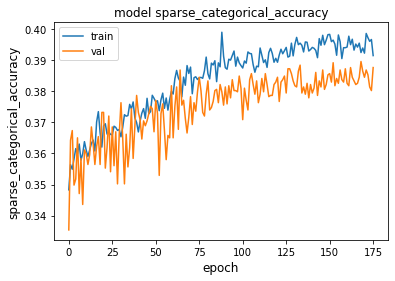

In [18]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [19]:
y = model.predict(x_test)

198/198 [==============================] - 1s 4ms/step


In [20]:
def myprint(i):
    global y
    global y_test
    print(y[i])
    print(y_test[i])

In [21]:
myprint(902)

[0.300637   0.3484316  0.35093147]
2


<BarContainer object of 50 artists>

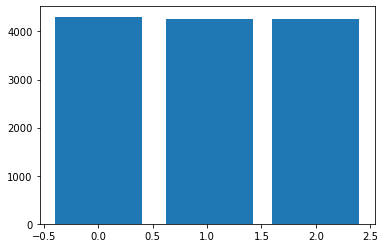

In [22]:
hist = np.histogram(y_train,bins=50)[0]
plt.bar(np.linspace(y_train.min(),y_train.max()),hist)

<BarContainer object of 50 artists>

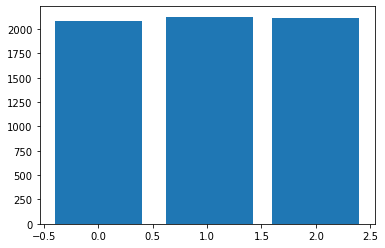

In [23]:
hist = np.histogram(y_test,bins=50)[0]
plt.bar(np.linspace(y_test.min(),y_test.max()),hist)